# Advanced lane finding

### Imports

In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Undistorsion

### Methods

In [2]:
# Pass an array of chessboard test images and the expected x*y dimension
# Images that do not fit an x by y board will be skipped.
def getCameraMatrix(images, nx, ny):
    objpoints = []
    imgpoints = []

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    for fname in images:
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        #else:
        #    print('image ', fname, ' failed to find chessboard')

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    print('mtx:  ', mtx)
    print('dist: ', dist)

    return mtx, dist # discard others, not going to use them


### Generate the calibration matrix
Get the 'mtx' and 'dist' values for our camera.

In [3]:
# Make a list of calibration images
directory = 'camera_cal/'
cal_files = os.listdir(directory)

# define the expected n*y chessboard
# (some of the test images won't fit)
nx = 9
ny = 6

cal_images = []
for filename in cal_files:
    if filename.endswith(".jpg"): 
        cal_images.append(directory + filename)
        
mtx, dist = getCameraMatrix(cal_images, nx, ny)


mtx:   [[  1.15662906e+03   0.00000000e+00   6.69041437e+02]
 [  0.00000000e+00   1.15169194e+03   3.88137239e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist:  [[-0.2315715  -0.12000538 -0.00118338  0.00023305  0.15641572]]


We will use these values for the rest of the project

### Test our matrix to correct distorsion for 2 images
Test on one of the calibration images and the sample test image I will use for the next steps.
I'm using 'test1.jpg' for testing because it has some light and shadow in the background and different asfalt tones. Tuning my filtering values to work with a medium quality image should provide best results for the friendlier ones.

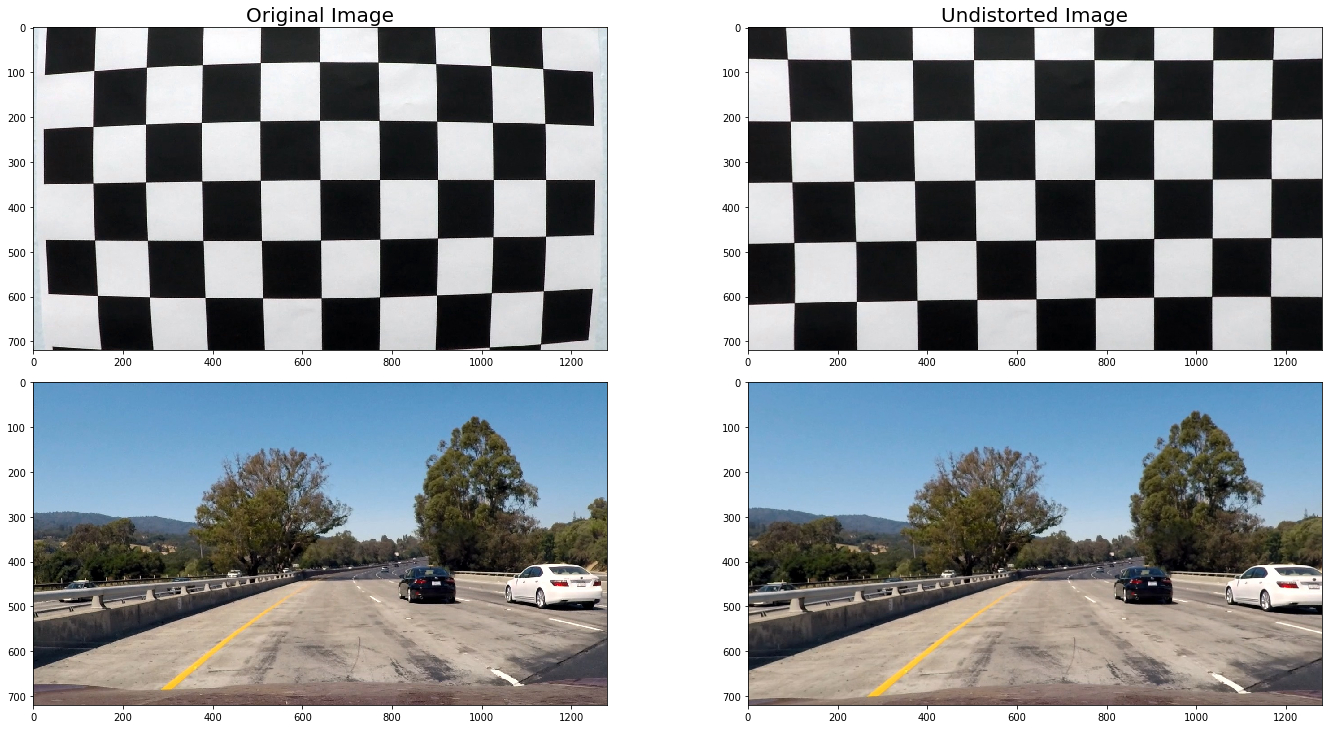

In [4]:
# Show output for an undistorted test image
# Compare the calibration undistorsion to a test image
example_img1 = cv2.imread('./camera_cal/calibration1.jpg')
example_dst1 = cv2.undistort(example_img1, mtx, dist, None, mtx)

example_img2 = cv2.imread('./test_images/test1.jpg', 1)
example_img2 = cv2.cvtColor(example_img2, cv2.COLOR_BGR2RGB)
example_dst2 = cv2.undistort(example_img2, mtx, dist, None, mtx)

# define a few more for quick testing in following stages    
example_img3 = cv2.imread('./test_images/test2.jpg')
example_img3 = cv2.cvtColor(example_img3, cv2.COLOR_BGR2RGB)
example_dst3 = cv2.undistort(example_img3, mtx, dist, None, mtx)

example_img4 = cv2.imread('./test_images/test3.jpg')
example_img4 = cv2.cvtColor(example_img4, cv2.COLOR_BGR2RGB)
example_dst4 = cv2.undistort(example_img4, mtx, dist, None, mtx)

example_img5 = cv2.imread('./test_images/test4.jpg')
example_img5 = cv2.cvtColor(example_img5, cv2.COLOR_BGR2RGB)
example_dst5 = cv2.undistort(example_img5, mtx, dist, None, mtx)

example_img6 = cv2.imread('./test_images/test5.jpg')
example_img6 = cv2.cvtColor(example_img6, cv2.COLOR_BGR2RGB)
example_dst6 = cv2.undistort(example_img6, mtx, dist, None, mtx)

example_img7 = cv2.imread('./test_images/test6.jpg')
example_img7 = cv2.cvtColor(example_img7, cv2.COLOR_BGR2RGB)
example_dst7 = cv2.undistort(example_img7, mtx, dist, None, mtx)

f, axes = plt.subplots(2, 2, figsize=(20,10))
f.tight_layout()
axes[0,0].set_title('Original Image', fontsize=20)
axes[0,0].imshow(example_img1)
axes[1,0].imshow(example_img2)
axes[0,1].set_title('Undistorted Image', fontsize=20)
axes[0,1].imshow(example_dst1)
axes[1,1].imshow(example_dst2)


Our camera is now calibrated

## Warping

### Methods

In [5]:
# Funtion to warp a portion of an image
def warp(image, offset=30, xd=2, yd=2):
    
    img_size = (image.shape[1], image.shape[0])
    [maxX, maxY] = (image.shape[1], image.shape[0])
    #print('maxX: ', maxX, 'maxY: ', maxY)

    # xd => changes the region of interest delta in the X-axis
    # yd => changes the region of interest delta in the Y-axis
    
    z = 20
    littleUnderHalfZx = ((z/2) - xd)/z
    littleOverHalfZx = ((z/2) + xd)/z
    littleOverHalfZy = ((z/2) + yd)/z
    lotUnderHalfZ = 0#1/z
    lotOverHalfZ = 1#(z-1)/z

    src = np.float32([
        # a b
        # c d
        [maxX*littleUnderHalfZx, maxY*littleOverHalfZy], # xy for a
        [maxX*littleOverHalfZx, maxY*littleOverHalfZy], # xy for b
        [maxX*lotUnderHalfZ, maxY], # xy for c
        [maxX*lotOverHalfZ, maxY] # xy for d
    ])

    dst = np.float32([
        # a b
        # c d
        [offset, offset], 
        [maxX-offset, offset], 
        [offset, maxY], 
        [maxX-offset, maxY]
    ])

    # Compute and apply perpective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, src, Minv


### Test warping our output undistorted image
It's clear in this example that the region of interest can drastically change the output. 1/20 of the size of the axis' size can produce very different interpolation results. Taking a look at the output you could asume that the aspect ratio of the region of interest seems to affect the result of the perspective transformation.

(-0.5, 1279.5, 719.5, -0.5)

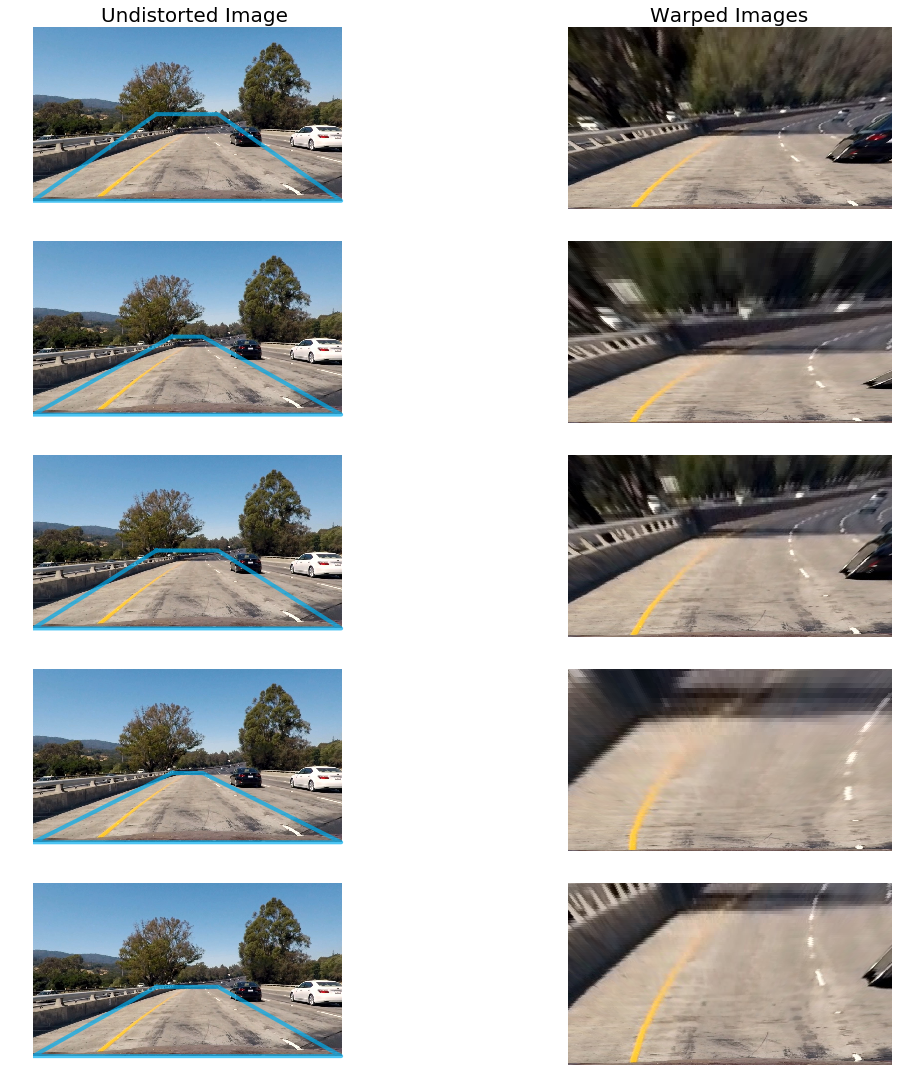

In [6]:
example_wrpd10, src, Minv = warp(example_dst2, 0, 2, 0)
x10 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y10 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

example_wrpd11, src, Minv = warp(example_dst2, 0, 1, 1)
x11 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y11 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

example_wrpd21, src, Minv = warp(example_dst2, 0, 2, 1)
x21 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y21 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

example_wrpd12, src, Minv = warp(example_dst2, 0, 1, 2)
x12 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y12 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

example_wrpd22, src, Minv = warp(example_dst2, 0, 2, 2)
x22 = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y22 = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

superColor = '#01ACED'
f, axes = plt.subplots(5, 2, figsize=(15,15))
f.tight_layout()
axes[0,0].set_title('Undistorted Image', fontsize=20)
axes[0,0].imshow(example_dst2)
axes[0,0].plot(x10, y10, color=superColor, alpha=0.7, linewidth=4)
axes[0,0].axis('off')

axes[1,0].imshow(example_dst2)
axes[1,0].plot(x11, y11, color=superColor, alpha=0.7, linewidth=4)
axes[1,0].axis('off')
axes[2,0].imshow(example_dst2)
axes[2,0].plot(x21, y21, color=superColor, alpha=0.7, linewidth=4)
axes[2,0].axis('off')
axes[3,0].imshow(example_dst2)
axes[3,0].plot(x12, y12, color=superColor, alpha=0.7, linewidth=4)
axes[3,0].axis('off')
axes[4,0].imshow(example_dst2)
axes[4,0].plot(x22, y22, color=superColor, alpha=0.7, linewidth=4)
axes[4,0].axis('off')

axes[0,1].set_title('Warped Images', fontsize=20)
axes[0,1].imshow(example_wrpd10)
axes[0,1].axis('off')
axes[1,1].imshow(example_wrpd11)
axes[1,1].axis('off')
axes[2,1].imshow(example_wrpd21)
axes[2,1].axis('off')
axes[3,1].imshow(example_wrpd12)
axes[3,1].axis('off')
axes[4,1].imshow(example_wrpd22)
axes[4,1].axis('off')


## Colorspaces

### Methods

In [7]:
def colorspace_threshold(img, x2yCvt, channel, thresh=(0, 255)):
    # 1) Convert to x2y color space
    if x2yCvt is not None: 
        colorConv = cv2.cvtColor(img, x2yCvt)
    else:
        colorConv = img
        
    colorChannel = colorConv[:,:,channel]
    colorChannel = colorChannel * (255/np.max(colorChannel)) # normalise
    
    # 2) Apply a threshold to the 'channel'
    binary = np.zeros_like(colorChannel)
    binary[(colorChannel > thresh[0]) & (colorChannel <= thresh[1])] = 1
    
    binary_output = np.copy(binary)
    
    # 3) Return a binary image of threshold result
    return binary_output


### Test the different color spaces
In order to check how the lane lines will show in the different color spaces, convert the warped image to different spaces and check how each channel shows the lines. Then we can decide which one is best to detect lines.

(-0.5, 1279.5, 719.5, -0.5)

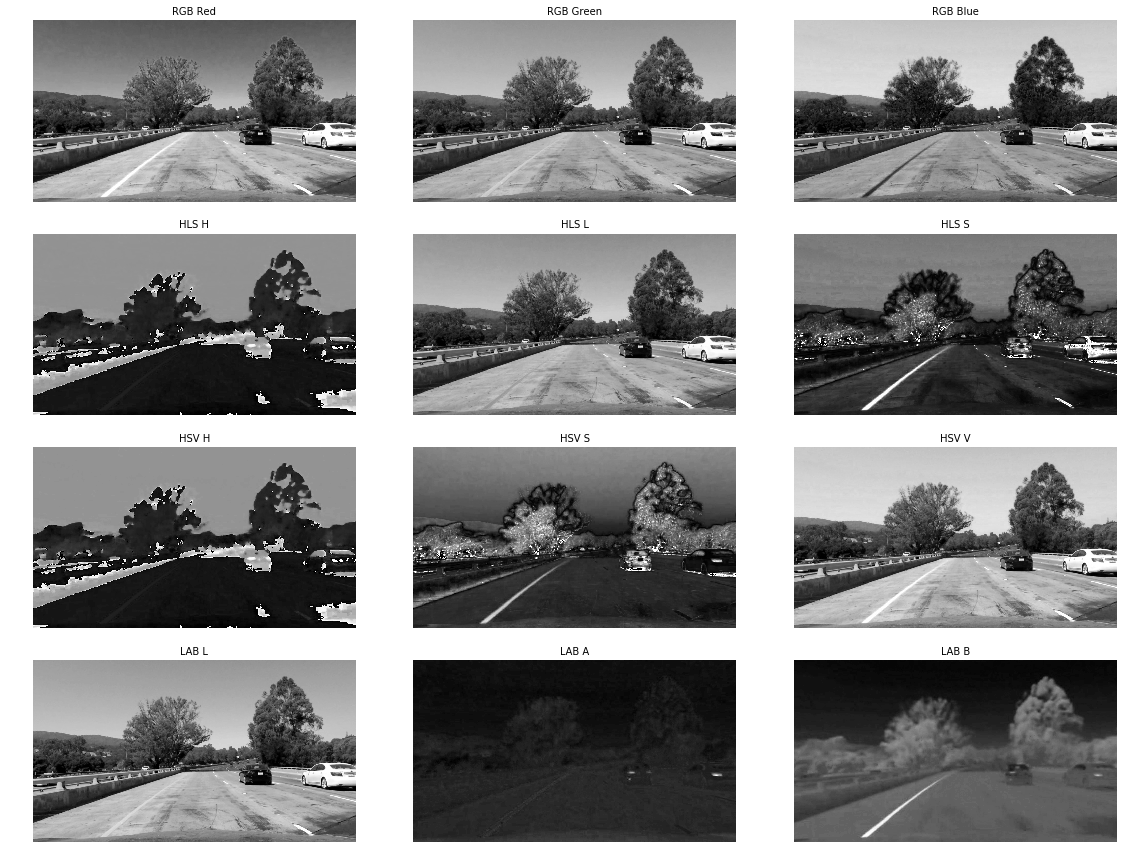

In [8]:
wrpd_source = example_dst2
#wrpd_source = example_wrpd12 # Taking the 1/2 or 2/2 iteration of the previous tests

# Sample the RBG color space
wrpd_source_RGB_R = wrpd_source[:,:,0]
wrpd_source_RGB_G = wrpd_source[:,:,1]
wrpd_source_RGB_B = wrpd_source[:,:,2]

# Sample the HLS color space
wrpd_source_HLS = cv2.cvtColor(wrpd_source, cv2.COLOR_RGB2HLS)
wrpd_source_HLS_H = wrpd_source_HLS[:,:,0]
wrpd_source_HLS_L = wrpd_source_HLS[:,:,1]
wrpd_source_HLS_S = wrpd_source_HLS[:,:,2]

# Sample the HSV color space
wrpd_source_HSV = cv2.cvtColor(wrpd_source, cv2.COLOR_RGB2HSV)
wrpd_source_HSV_H = wrpd_source_HSV[:,:,0]
wrpd_source_HSV_S = wrpd_source_HSV[:,:,1]
wrpd_source_HSV_V = wrpd_source_HSV[:,:,2]

# Sample the LAB color space
wrpd_source_LAB = cv2.cvtColor(wrpd_source, cv2.COLOR_RGB2Lab)
wrpd_source_LAB_L = wrpd_source_LAB[:,:,0]
wrpd_source_LAB_A = wrpd_source_LAB[:,:,1]
wrpd_source_LAB_B = wrpd_source_LAB[:,:,2]

f, axes = plt.subplots(4,3, figsize=(16, 12))
f.tight_layout()
axes[0,0].set_title('RGB Red', fontsize=10)
axes[0,0].imshow(wrpd_source_RGB_R, cmap='gray')
axes[0,0].axis('off')
axes[0,1].set_title('RGB Green', fontsize=10)
axes[0,1].imshow(wrpd_source_RGB_G, cmap='gray')
axes[0,1].axis('off')
axes[0,2].set_title('RGB Blue', fontsize=10)
axes[0,2].imshow(wrpd_source_RGB_B, cmap='gray')
axes[0,2].axis('off')

axes[1,0].set_title('HLS H', fontsize=10)
axes[1,0].imshow(wrpd_source_HLS_H, cmap='gray')
axes[1,0].axis('off')
axes[1,1].set_title('HLS L', fontsize=10)
axes[1,1].imshow(wrpd_source_HLS_L, cmap='gray')
axes[1,1].axis('off')
axes[1,2].set_title('HLS S', fontsize=10)
axes[1,2].imshow(wrpd_source_HLS_S, cmap='gray')
axes[1,2].axis('off')

axes[2,0].set_title('HSV H', fontsize=10)
axes[2,0].imshow(wrpd_source_HSV_H, cmap='gray')
axes[2,0].axis('off')
axes[2,1].set_title('HSV S', fontsize=10)
axes[2,1].imshow(wrpd_source_HSV_S, cmap='gray')
axes[2,1].axis('off')
axes[2,2].set_title('HSV V', fontsize=10)
axes[2,2].imshow(wrpd_source_HSV_V, cmap='gray')
axes[2,2].axis('off')

axes[3,0].set_title('LAB L', fontsize=10)
axes[3,0].imshow(wrpd_source_LAB_L, cmap='gray')
axes[3,0].axis('off')
axes[3,1].set_title('LAB A', fontsize=10)
axes[3,1].imshow(wrpd_source_LAB_A, cmap='gray')
axes[3,1].axis('off')
axes[3,2].set_title('LAB B', fontsize=10)
axes[3,2].imshow(wrpd_source_LAB_B, cmap='gray')
axes[3,2].axis('off')


### Some interesting binaries of color channels
HLS S Channel yields a much cleaner binary with a much more permissive threshold

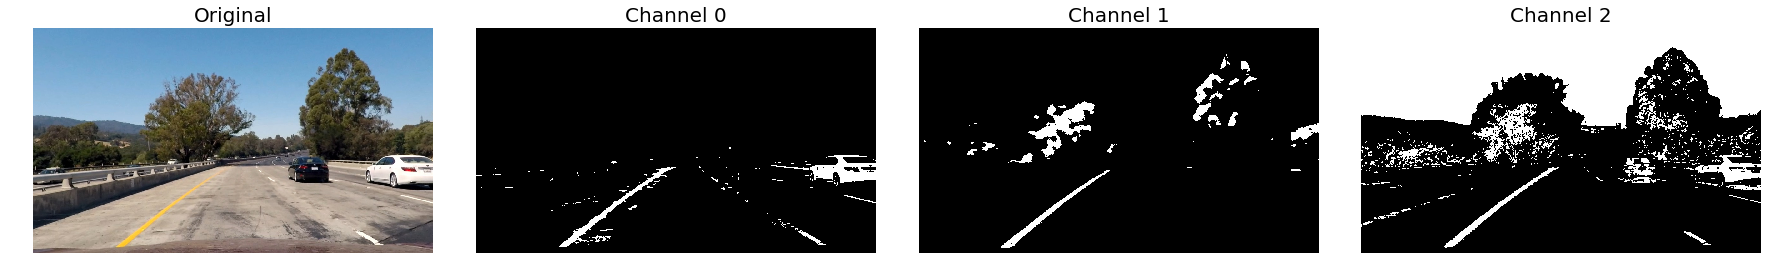

In [9]:
wrpd_source = example_dst2
#wrpd_source = example_wrpd22

# channels f.ex. (H S V) => (0, 1, 2)
#COLOR_RGB2HSV (S is best, H is good)
#COLOR_RGB2HLS (S is best, H is good)
#COLOR_RGB2Lab (B is best, L is good)
wrpd_source0 = colorspace_threshold(wrpd_source, None, 0, (210, 255))
wrpd_source1 = colorspace_threshold(wrpd_source, cv2.COLOR_RGB2Lab, 2, (180, 255))
wrpd_source2 = colorspace_threshold(wrpd_source, cv2.COLOR_RGB2HLS, 2, (90, 255))

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Channel 0', fontsize=20)
ax2.imshow(wrpd_source0, cmap='gray')
ax2.axis('off')
ax3.set_title('Channel 1', fontsize=20)
ax3.imshow(wrpd_source1, cmap='gray')
ax3.axis('off')
ax4.set_title('Channel 2', fontsize=20)
ax4.imshow(wrpd_source2, cmap='gray')
ax4.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### Get a combined binary mix of all the good ones

(-0.5, 1279.5, 719.5, -0.5)

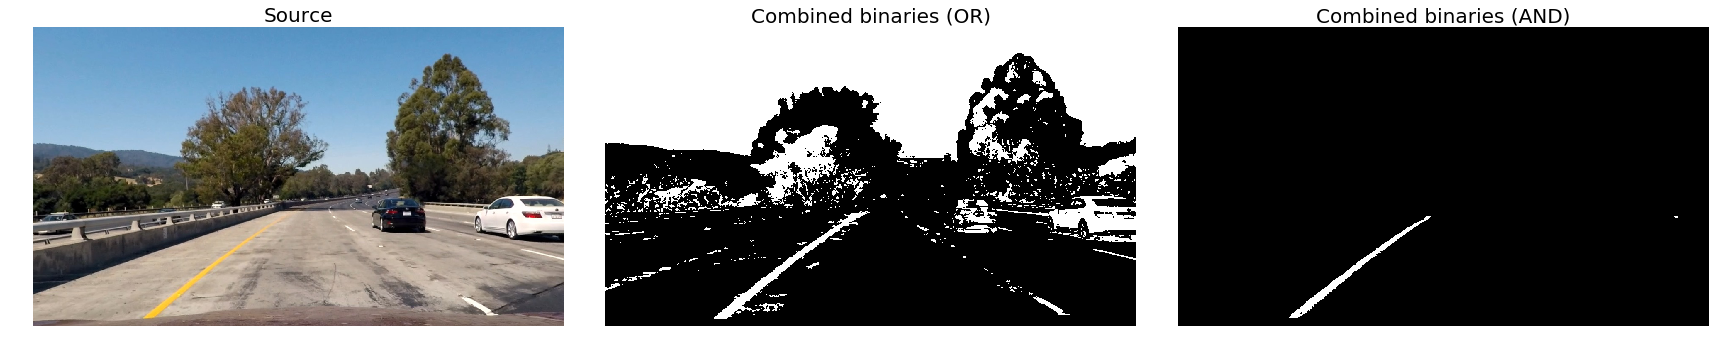

In [10]:
wrpd_source = example_dst2
#wrpd_source = example_wrpd22

# using results from previous test
ord_combined_binaries = np.zeros_like(wrpd_source0)
ord_combined_binaries[(wrpd_source0 == 1) | (wrpd_source1 == 1) | (wrpd_source2 == 1)] = 1

andd_combined_binaries = np.zeros_like(wrpd_source0)
andd_combined_binaries[(wrpd_source0 == 1) & (wrpd_source1 == 1) & (wrpd_source2 == 1)] = 1

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Source', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Combined binaries (OR)', fontsize=20)
ax2.imshow(ord_combined_binaries, cmap='gray')
ax2.axis('off')
ax3.set_title('Combined binaries (AND)', fontsize=20)
ax3.imshow(andd_combined_binaries, cmap='gray')
ax3.axis('off')

### Extract the test results into a single method

In [11]:
# I'm taking 3/4 channels and filtering each channel in its best region.
def binary_frame(image, mtx, dist, wrp):
    #thresh_r = (0, 50)
    # RGB already
    #warped_RGB_R = np.zeros_like(warped)
    #warped_RGB_R = warped[:,:,0]
    #warped_RGB_R[(warped_RGB_R > thresh_r[0]) & (warped_RGB_R <= thresh_r[1])] = 1
    
    #thresh_h = (90, 255)
    #warped_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    #warped_HLS_H = np.zeros_like(warped_HLS)
    #warped_HLS_H = warped[:,:,0]
    #warped_HLS_H[(warped_HLS_H > thresh_h[0]) & (warped_HLS_H <= thresh_h[1])] = 1

    #thresh_s = (90, 255)
    #warped_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    #warped_HLS_S = np.zeros_like(warped_HLS)
    #warped_HLS_S = warped[:,:,2]
    #warped_HLS_S[(warped_HLS_S > thresh_s[0]) & (warped_HLS_S <= thresh_s[1])] = 1

    #thresh_b = (220, 255)
    #warped_LAB = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)
    #warped_LAB_B = np.zeros_like(warped_LAB)
    #warped_LAB_B = warped[:,:,0]
    #warped_LAB_B[(warped_LAB_B > thresh_b[0]) & (warped_LAB_B <= thresh_b[1])] = 1

    RGB_channel_R = colorspace_threshold(image, None, 0, (210, 255))
    #HLS_channel_H = colorspace_threshold(image, cv2.COLOR_RGB2HLS, 0, (90, 255))
    LAB_channel_B = colorspace_threshold(image, cv2.COLOR_RGB2Lab, 2, (200, 255))
    HLS_channel_S = colorspace_threshold(image, cv2.COLOR_RGB2HLS, 2, (90, 255))

    combined_binaries = np.zeros_like(RGB_channel_R)
    combined_binaries[
        (RGB_channel_R == 1) |
        #(HLS_channel_H == 1) #|
        (LAB_channel_B == 1) |
        (HLS_channel_S == 1)
    ] = 1

    warped, src, Minv = warp(combined_binaries, 50, wrp[0], wrp[1])

    return np.copy(warped), src, Minv


### Test our master colorspace binarisation method

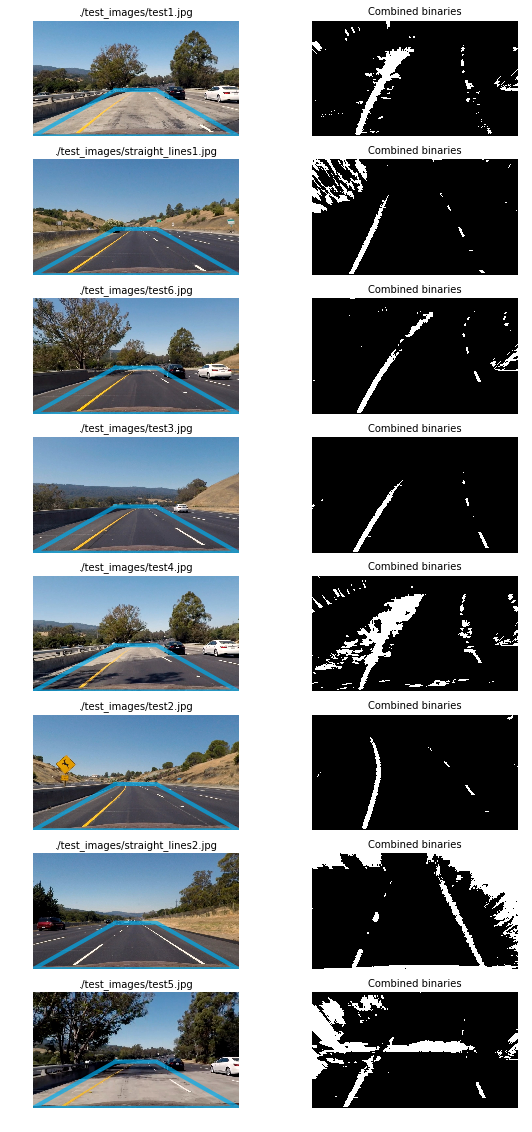

In [12]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axes = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

i = 0
for filename in images:
    image = cv2.imread(filename)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_undist = cv2.undistort(image_rgb, mtx, dist, None, mtx)
    image_bin, src, Minv = binary_frame(image_undist, mtx, dist, (2,2))
    
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

    axes[i].set_title(filename, fontsize=10)
    axes[i].plot(x, y, color='#01ACED', alpha=0.7, linewidth=4)
    axes[i].imshow(image_undist)
    axes[i].axis('off')
    i += 1
    axes[i].set_title('Combined binaries', fontsize=10)
    axes[i].imshow(image_bin, cmap='gray')
    axes[i].axis('off')
    i += 1


## Sobel binarisation

### Methods

In [13]:
# Function that applies Sobel x or y, then takes 
# an absolute value and applies a threshold.
def abs_sobel_threshold(img, orient='x', thresh=(0, 255)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sbinary)
    return binary_output

# Function that applies Sobel x and y, then computes 
# the magnitude of the gradient and applies a threshold
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Function that applies Sobel x and y, then computes 
# the direction of the gradient and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Combine all 4 possible Sobel measures into a single image
def combined_threshold(img, sobel_kernel=3, athresh=(20, 100), mthresh=(0, 255), dthresh=(0, np.pi/2)):
    gradx = abs_sobel_threshold(img, 'x', athresh)
    grady = abs_sobel_threshold(img, 'y', athresh)
    mag_binary = mag_threshold(img, sobel_kernel, mthresh)
    dir_binary = dir_threshold(img, sobel_kernel, dthresh)
    combined_output = np.zeros_like(dir_binary)
    combined_output[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_output


### Test the different Sobel binarisation methods

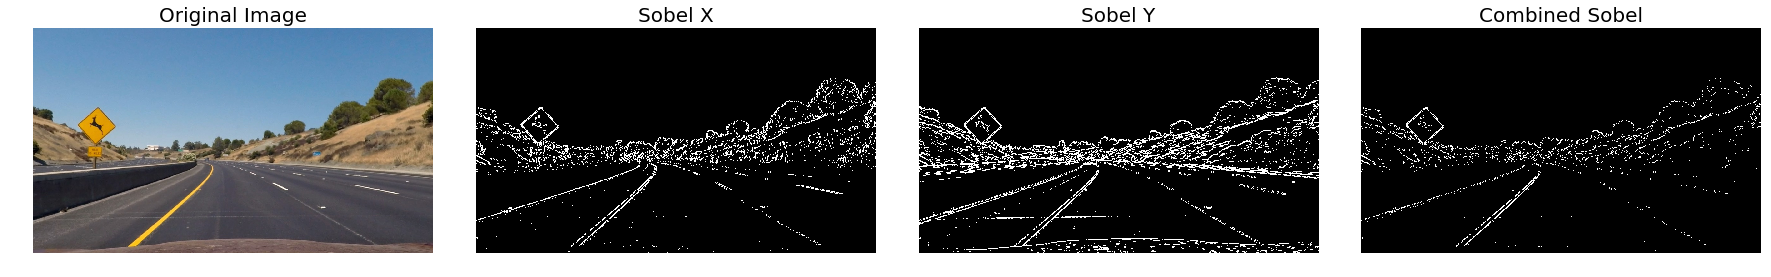

In [14]:
wrpd_source = example_dst3
#wrpd_source = example_wrpd12

thresh = (20, 100)
grad_binary_x = abs_sobel_threshold(wrpd_source, 'x', thresh)
grad_binary_y = abs_sobel_threshold(wrpd_source, 'y', thresh)

combined = np.zeros_like(grad_binary_x)
combined[((grad_binary_x == 1) & (grad_binary_y == 1))] = 1

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Sobel X', fontsize=20)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.axis('off')
ax3.set_title('Sobel Y', fontsize=20)
ax3.imshow(grad_binary_y, cmap='gray')
ax3.axis('off')
ax4.set_title('Combined Sobel', fontsize=20)
ax4.imshow(combined, cmap='gray')
ax4.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


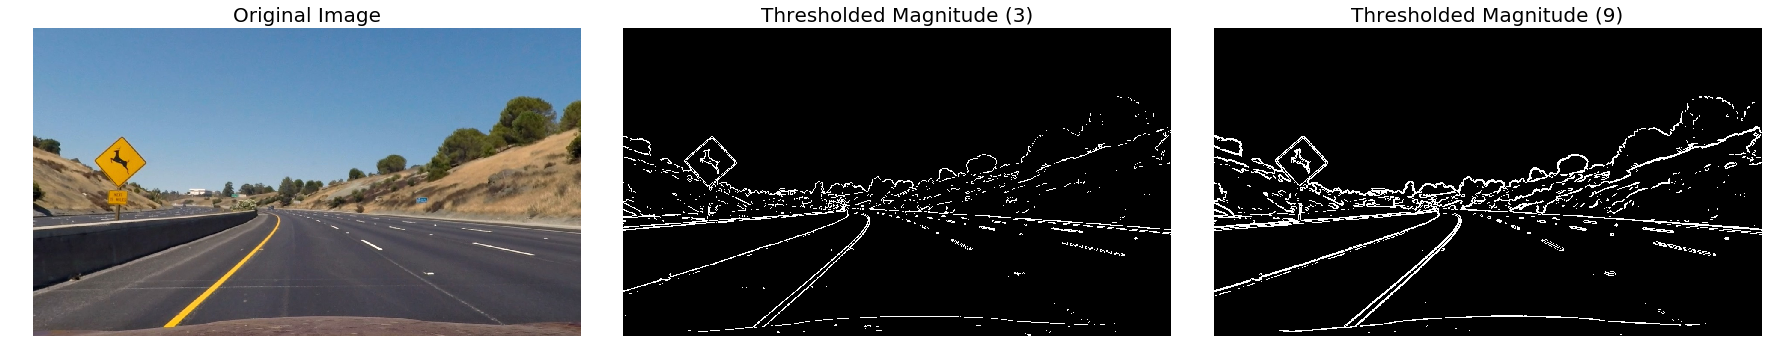

In [15]:
wrpd_source = example_dst3
#wrpd_source = example_wrpd12

thresh = (50, 170)
mag_binary3 = mag_threshold(wrpd_source, 3, thresh)
mag_binary9 = mag_threshold(wrpd_source, 9, thresh)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Thresholded Magnitude (3)', fontsize=20)
ax2.imshow(mag_binary3, cmap='gray')
ax2.axis('off')
ax3.set_title('Thresholded Magnitude (9)', fontsize=20)
ax3.imshow(mag_binary9, cmap='gray')
ax3.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# looks cleaner with kernel 3 


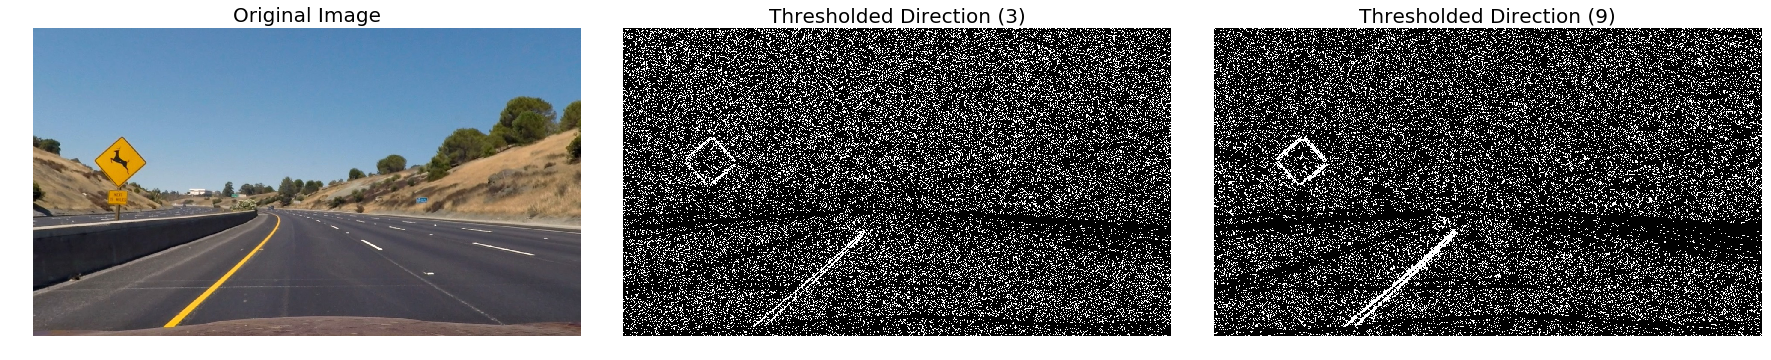

In [16]:
wrpd_source = example_dst3
#wrpd_source = example_wrpd12

thresh = (np.pi/2 * (4/10), np.pi/2 * (6/10))
dir_binary3 = dir_threshold(wrpd_source, 3, thresh)
dir_binary9 = dir_threshold(wrpd_source, 9, thresh)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Thresholded Direction (3)', fontsize=20)
ax2.imshow(dir_binary3, cmap='gray')
ax2.axis('off')
ax3.set_title('Thresholded Direction (9)', fontsize=20)
ax3.imshow(dir_binary9, cmap='gray')
ax3.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# kernel 9 seems to show a side line better (although it's not a lane)


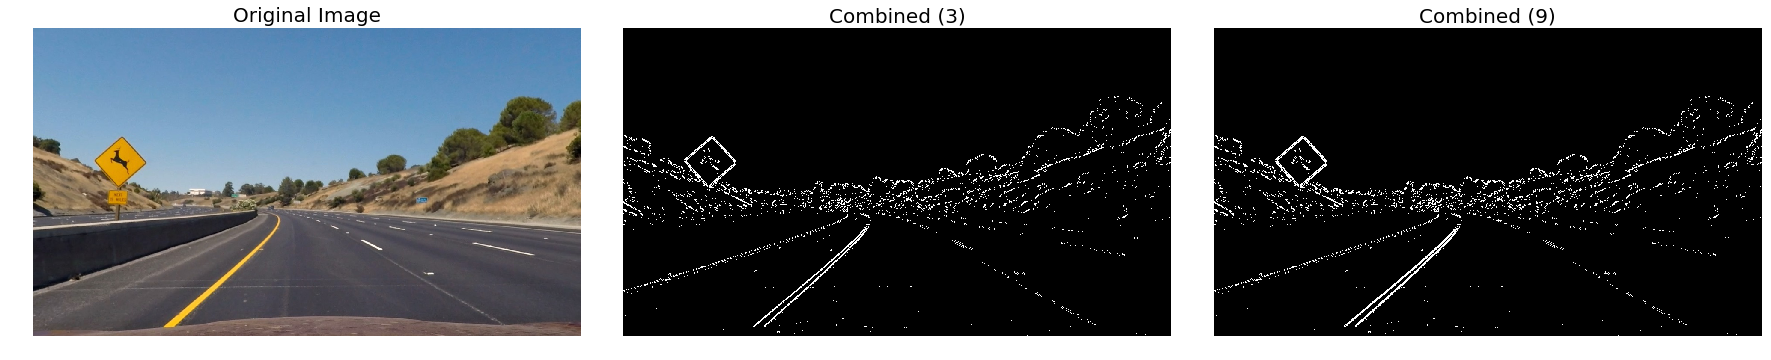

In [17]:
wrpd_source = example_dst3
#wrpd_source = example_wrpd12

abs_thresh = (20, 100)
mag_thresh = (50, 170)
dir_thresh = (np.pi/2 * (4/10), np.pi/2 * (6/10))
comb_binary3 = combined_threshold(wrpd_source, 3, abs_thresh, mag_thresh, dir_thresh)
comb_binary9 = combined_threshold(wrpd_source, 9, abs_thresh, mag_thresh, dir_thresh)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(wrpd_source)
ax1.axis('off')
ax2.set_title('Combined (3)', fontsize=20)
ax2.imshow(comb_binary3, cmap='gray')
ax2.axis('off')
ax3.set_title('Combined (9)', fontsize=20)
ax3.imshow(comb_binary9, cmap='gray')
ax3.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# still better with kernel 3


### Extract the test results into a single method

In [18]:
def sobel_frame(image, mtx, dist, wrp):
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    abs_thresh = (20, 100)
    mag_thresh = (50, 170)
    dir_thresh = (np.pi/2 * (4/10), np.pi/2 * (6/10))
    sobel_binary = combined_threshold(undist, 9, abs_thresh, mag_thresh, dir_thresh)

    warped, src, Minv = warp(sobel_binary, 50, wrp[0], wrp[1])

    return warped, Minv
    

### Test our master Sobel binarisation method

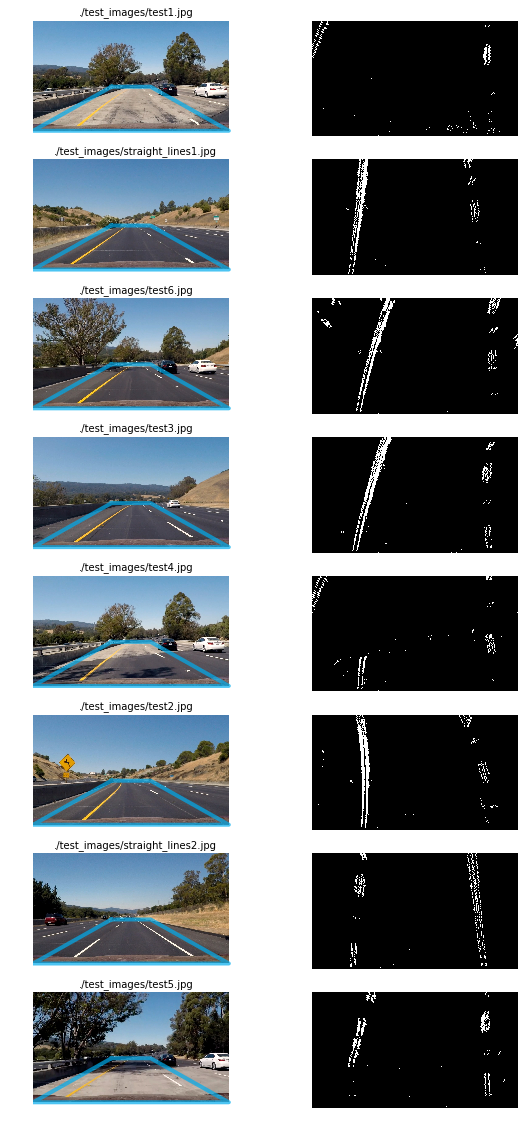

In [19]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')

# Set up plot
fig, axes = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

i = 0
for filename in images:
    image = cv2.imread(filename)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_sob, Minv = sobel_frame(image_rgb, mtx, dist, (2, 3))
    
    axes[i].set_title(filename, fontsize=10)
    axes[i].imshow(image_rgb)
    axes[i].axis('off')
    axes[i].plot(x, y, color='#01ACED', alpha=0.7, linewidth=4)
    i += 1
    axes[i].imshow(image_sob, cmap='gray')
    axes[i].axis('off')
    i += 1


### Now test both binarisation methods together
Compute a general binarisation of all test images and add a histogram of the output

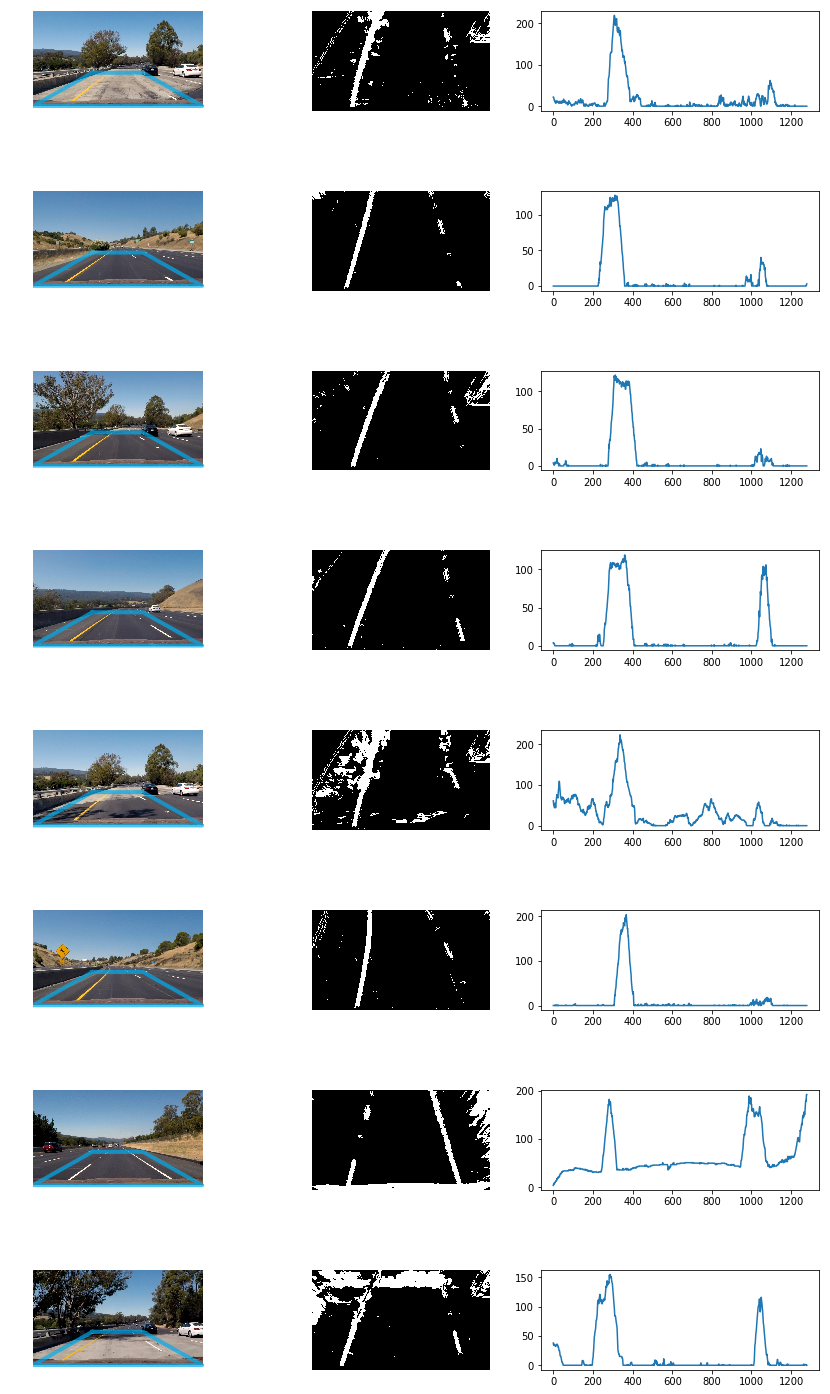

In [20]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')

# Set up plot
fig, axes = plt.subplots(len(images),3, figsize=(15, 25))
fig.subplots_adjust(hspace = .8, wspace=.001)
axes = axes.ravel()

i = 0
for image in images:
    image = cv2.imread(image)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    wrp = (3, 3)
    image_sob, Minv = sobel_frame(image_rgb, mtx, dist, wrp)
    image_bin, src, Minv = binary_frame(image_rgb, mtx, dist, wrp)
    
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

    image_final = np.zeros_like(image_bin)
    #image_final[(image_sob == 1) & (image_bin == 1)] = 1
    image_final[(image_sob == 1) | (image_bin == 1)] = 1
    
    bottom_half = image_final[image_final.shape[0]//2:,:]
    image_hist = np.sum(bottom_half, axis=0)
    
    axes[i].imshow(image_rgb)
    axes[i].axis('off')
    axes[i].plot(x, y, color='#01ACED', alpha=0.7, linewidth=4)
    i += 1
    axes[i].imshow(image_final, cmap='gray')
    axes[i].axis('off')
    i += 1
    axes[i].plot(image_hist)
    i += 1


## Define a master pipeline for processing an image

In [21]:
def pipeline(image_rgb, mtx, dist, wrp):
    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_bin, src, Minv = binary_frame(image_rgb, mtx, dist, wrp)
    image_sob, Minv = sobel_frame(image_rgb, mtx, dist, wrp)

    # Ideally I'd like to AND both outputs, but colorspace filtering gives me lines
    # and sobel filtering gives me line edges, so ANDing the outputs ends up producing
    # almost empty images. ORing them gives nice lines, but also doubles the noise
    #
    # Hunch...
    # ANDing outputs will work better with more tolerant colorspace and sobel filtering
    # ORing output will work better with more restricting colorspace and sobel filtering
    #
    image_final = np.zeros_like(image_bin)
    #image_final[(image_sob == 1) & (image_bin == 1)] = 1
    image_final[(image_sob == 1) | (image_bin == 1)] = 1
    
    return image_final, src, Minv


## Find lane pixels and calculate a polynomial fit

### Methods

In [22]:
def find_lane_pixels(binary_warped, nwindows=15, margin=100, minpix=80):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    pleftx_current = leftx_current
    prightx_current = rightx_current
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = (
                (nonzeroy >= win_y_low) & 
                (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) & 
                (nonzerox < win_xleft_high)
            ).nonzero()[0]
        
        good_right_inds = (
                (nonzeroy >= win_y_low) & 
                (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) & 
                (nonzerox < win_xright_high)
            ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        # else, take then tendency and slowly fade it out
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            pleftx_current = leftx_current
        else:
            leftx_current = np.int(0.9*pleftx_current)
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            prightx_current = rightx_current
        else:
            rightx_current = np.int(0.9*prightx_current)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #return out_img, leftx, lefty, rightx, righty
    return leftx, lefty, rightx, righty

def fit_polynomial(ploty, leftx, lefty, rightx, righty):        
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return (left_fit, right_fit), (left_fitx, right_fitx)

def search_around_poly(binary_warped, pleft_fit, pright_fit, margin=100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((
        nonzerox > 
            (pleft_fit[0]*(nonzeroy**2) + pleft_fit[1]*nonzeroy + pleft_fit[2] - margin)
        ) & (
        nonzerox < 
            (pleft_fit[0]*(nonzeroy**2) + pleft_fit[1]*nonzeroy + pleft_fit[2] + margin)
        ))
    right_lane_inds = ((
        nonzerox > 
            (pright_fit[0]*(nonzeroy**2) + pright_fit[1]*nonzeroy + pright_fit[2] - margin)
        ) & (
        nonzerox < 
            (pright_fit[0]*(nonzeroy**2) + pright_fit[1]*nonzeroy + pright_fit[2] + margin)
        ))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # New fits
    nleft_fit = None
    nright_fit = None
    
    if len(leftx) != 0: 
        nleft_fit = np.polyfit(lefty, leftx, 2)
        nleft_fitx = nleft_fit[0]*ploty**2 + nleft_fit[1]*ploty + nleft_fit[2]


    if len(rightx) != 0: 
        nright_fit = np.polyfit(righty, rightx, 2)
        nright_fitx = nright_fit[0]*ploty**2 + nright_fit[1]*ploty + nright_fit[2]

    return (nleft_fit, nright_fit), (nleft_fitx, nright_fitx), (left_lane_inds, right_lane_inds)


### Test the pipeline and fit a polynomial

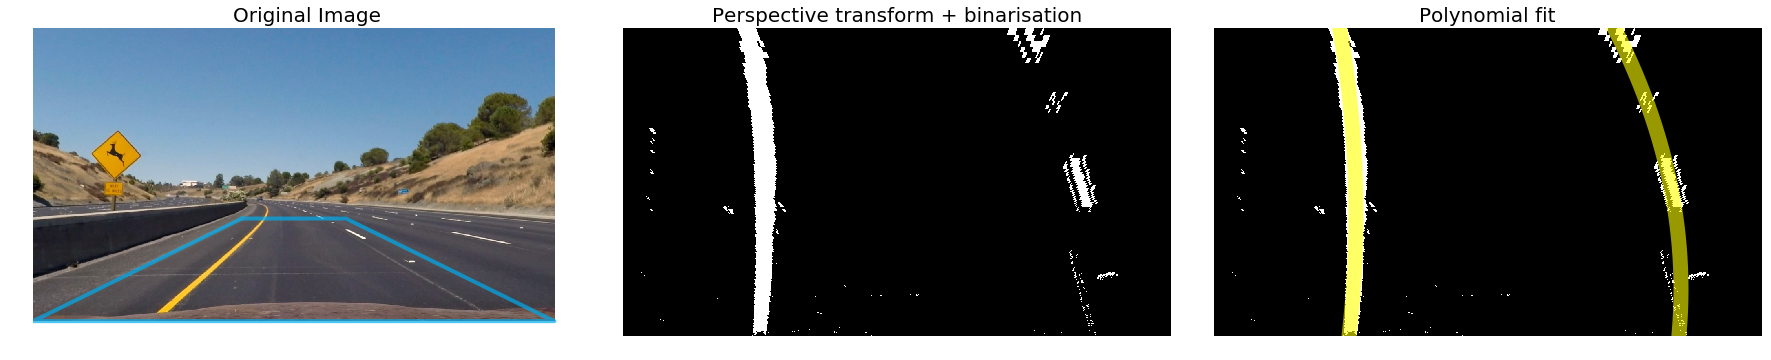

In [23]:
wrpd_source = example_dst3

image_binary, src, Minv = pipeline(wrpd_source, mtx, dist, (2, 3))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

ploty = np.linspace(0, image_binary.shape[0]-1, image_binary.shape[0])

leftx, lefty, rightx, righty = find_lane_pixels(image_binary)
fit, fitx = fit_polynomial(ploty, leftx, lefty, rightx, righty)

# Colors in the left and right lane regions
#image_polyfit[lefty, leftx] = [0, 0, 255]
#image_polyfit[righty, rightx] = [0, 0, 255]

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(wrpd_source)
ax1.plot(x, y, color='#01ACED', alpha=0.7, linewidth=4)
ax1.axis('off')

ax2.set_title('Perspective transform + binarisation', fontsize=20)
ax2.imshow(image_binary, cmap='gray')
ax2.axis('off')

ax3.set_title('Polynomial fit', fontsize=20)
ax3.plot(fitx[0], ploty, color='yellow', alpha=0.6, linewidth=15)
ax3.plot(fitx[1], ploty, color='yellow', alpha=0.6, linewidth=15)
ax3.imshow(image_binary, cmap='gray')
ax3.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Perform a polynomial calculation on two consecutive (?) frames

Region of interest from last frame detetion results and new found polynomial fit: 


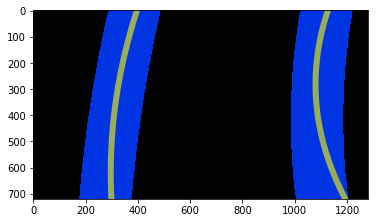

In [24]:
# Possible consecutive frames to use for tests?
#  Frame 1 (test1 => example_dst2)
#  Frame 2 (test4 => example_dst5)
#  Frame 3 (test6 => example_dst7)
#  Frame 4 (test5 => example_dst6)
first_frame = example_dst2
second_frame = example_dst5

ploty = np.linspace(0, first_frame.shape[0]-1, first_frame.shape[0] )
wrp = (2, 3)

# Previous (or current) frame
pimage_binary, src, Minv = pipeline(first_frame, mtx, dist, wrp)
leftx, lefty, rightx, righty = find_lane_pixels(pimage_binary)
pfit, pfitx = fit_polynomial(ploty, leftx, lefty, rightx, righty)

# Next frame
margin = 100
nimage_binary, src, Minv = pipeline(second_frame, mtx, dist, wrp)
nfit, nfitx, nlane_inds = search_around_poly(nimage_binary, pfit[0], pfit[1], margin)

## Visualization ##
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((pimage_binary, pimage_binary, pimage_binary))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
#out_img[nonzeroy[nleft_lane_inds], nonzerox[nleft_lane_inds]] = [255, 0, 0]
#out_img[nonzeroy[nright_lane_inds], nonzerox[nright_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (using previous polynomial)
# And recast the x and y points into usable format for cv2.fillPoly()

left_line_window1 = np.array([np.transpose(np.vstack([pfitx[0]-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([pfitx[0]+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([pfitx[1]-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([pfitx[1]+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 100))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 100))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the new polynomial lines onto the image
plt.plot(nfitx[0], ploty, color='yellow', alpha=0.6, linewidth=6)
plt.plot(nfitx[1], ploty, color='yellow', alpha=0.6, linewidth=6)
plt.imshow(result)

print('Region of interest from last frame detetion results and new found polynomial fit: ')

## Measure curvature of the lane polynomials

### Methods

In [25]:
def lane_curvature(leftx, lefty, rightx, righty, xRegion, yRegion, y_eval):

    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 1.5 * 3.7 / xRegion # assume 1.x lane widths in the region of interest
    ym_per_pix = 18 / yRegion        # assume 18 meters in the region of interest

    #print('curv   | x m/p: ', xm_per_pix, ', y m/p: ', ym_per_pix, ' (', xRegion, 'x', yRegion, ')')

    # Fit new polynomials to x,y in world space
    lPoly = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    rPoly = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*lPoly[0]*y_eval*ym_per_pix + lPoly[1])**2)**1.5) / np.absolute(2*lPoly[0])
    right_curverad = ((1 + (2*rPoly[0]*y_eval*ym_per_pix + rPoly[1])**2)**1.5) / np.absolute(2*rPoly[0])
    
    return left_curverad, right_curverad

def deviance_to_lane_center(leftx, lefty, rightx, righty, xRegion, yRegion, y_eval):
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 1.5 * 3.7 / xRegion # assume 1.x lane widths in the region of interest
    ym_per_pix = 18 / yRegion        # assume 18 meters in the region of interest

    #print('center | x m/p: ', xm_per_pix, ', y m/p: ', ym_per_pix, ' (', xRegion, 'x', yRegion, ')')
    
    # Fit new polynomials to x,y in world space
    lPoly = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    rPoly = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # get value of poly
    left_curverad = lPoly[0]*y_eval**2 + lPoly[1]*y_eval + lPoly[2]
    right_curverad = rPoly[0]*y_eval**2 + rPoly[1]*y_eval + rPoly[2]

    car_position = xRegion / 2 # assume camera is in the center of the car
    lane_center = (left_curverad + right_curverad) / 2 # average of both lanes lines
    
    return (car_position - lane_center) * xm_per_pix

def draw_lane_stats(image, avg_curv, lane_deviance):
    
    image_copy = np.copy(image)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(avg_curv) + 'm'
    cv2.putText(image_copy, text, (40,70), font, 1, (0,255,155), 2, cv2.LINE_AA)
    direction = 'right'
    if lane_deviance < 0:
        direction = 'left'
    abs_lane_deviance = abs(lane_deviance)
    text = 'Car deviates ' + '{:04.2f}'.format(abs_lane_deviance) + 'm to the ' + direction
    cv2.putText(image_copy, text, (40,120), font, 1, (0,255,155), 2, cv2.LINE_AA)
    return image_copy

def draw_lane(image_color, image_binary, ploty, left_fitx, right_fitx, Minv):
    
    image_copy = np.copy(image_color)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))  
    return cv2.addWeighted(image_copy, 1, newwarp, 0.3, 0) # Combine the result with the original image


### Define a process_frame method

In [26]:
def process_frame(image_rgb):
    image_undist = cv2.undistort(image_rgb, mtx, dist, None, mtx)
    #image_warped, src, Minv = warp(image_undist, 0, 2, 3)

    image_binary, src, Minv = pipeline(image_undist, mtx, dist, (3, 3.5))
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

    ploty = np.linspace(0, image_binary.shape[0]-1, image_binary.shape[0])

    leftx, lefty, rightx, righty = find_lane_pixels(image_binary)
    fit, fitx = fit_polynomial(ploty, leftx, lefty, rightx, righty)

    xRegion = image_binary.shape[1]
    yRegion = image_binary.shape[0]

    # Define y-values where we want radius of curvature
    maxY = np.max(ploty)

    left_curverad, right_curverad = lane_curvature(leftx, lefty, rightx, righty, xRegion, yRegion, maxY)
    lane_deviance = deviance_to_lane_center(leftx, lefty, rightx, righty, xRegion, yRegion, maxY)

    avg_curvature = (left_curverad + right_curverad) / 2
    #print('Curvature: ', round(avg_curvature, 2), 'm | Delta from lane center: ', round(lane_deviance, 2), 'm')

    image_annotated = draw_lane_stats(image_undist, avg_curvature, lane_deviance)
    image_annotated = draw_lane(image_annotated, image_binary, ploty, fitx[0], fitx[1], Minv)
    return image_annotated, image_binary


### Test the pipeline

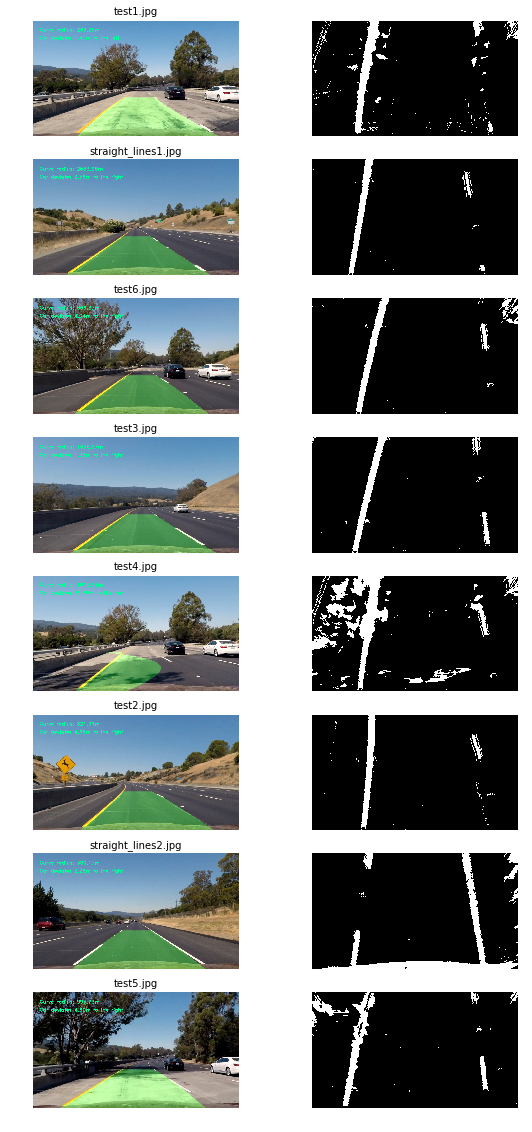

In [27]:
# Make a list of calibration images
srcDir = './test_images/'
dstDir = './test_images_output/'
srcFiles = os.listdir(srcDir)

# Set up plot
fig, axes = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

i = 0
for filename in srcFiles:
    if filename.endswith(".jpg"): 
        image = cv2.imread(srcDir + filename)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_annotated, image_binary = process_frame(image_rgb)
        
        axes[i].set_title(filename, fontsize=10)
        axes[i].imshow(image_annotated)
        axes[i].axis('off')
        #axes[i].plot(x, y, color='#01ACED', alpha=0.7, linewidth=4)
        i += 1
        axes[i].imshow(image_binary, cmap='gray')
        axes[i].axis('off')
        i += 1

        cv2.imwrite(dstDir + filename, image_annotated)
